# Compute $C_{\ell}$ from DESI iron data 

- [ ] Compute $\delta$ with PCA_qsonic
- [ ] $C^{-1}$ weighting of each forest
- [ ] compute mean delta for each line of sight
- [ ] save {RA, DEC, Z, $\delta$}

In [2]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt

In [3]:
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution

env: JAX_ENABLE_X64=True


CUDA backend failed to initialize: Found cuBLAS version 120201, but JAX was built against version 120304, which is newer. The copy of cuBLAS that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## load DESI data

In [4]:
def read_data(file_path):
    # Load data from the text file
    data = np.loadtxt(file_path)

    # Extract column names from the header
    with open(file_path, 'r') as file:
        header = file.readline().strip()
        column_names = header.split()

    # Create a dictionary to store data with column names
    data_dict = {}
    column_names = column_names[1:]
    for i, column_name in enumerate(column_names):
        data_dict[column_name] = data[:, i]

    return column_names, data_dict

In [5]:
version = 'v_0.8'
# Example usage:
file_path = f'/pscratch/sd/r/rmvd2/DESI/qsonic_contfit/iron/{version}/mean_delta_maps_cmbxlya/ra_dec_iron.txt'
column_names, data = read_data(file_path)
print(column_names)


['RA', 'Dec', 'Mean_Z', 'Mean_Z_Weighted', 'TID', 'Mean_Delta_W', 'Mean_Delta', 'Sum_Weight', 'num_pix']


In [6]:
ra = data['RA']
dec = data['Dec']
mean_z = data['Mean_Z']
mean_z_weight = data['Mean_Z_Weighted']
tid = data['TID']
Mean_Delta_W = data['Mean_Delta_W']
Mean_Delta = data['Mean_Delta']
Sum_Weight = data['Sum_Weight']
num_pix = data['num_pix']
mean_weight = Sum_Weight/num_pix
Mean_Delta_W_all = np.mean(Mean_Delta_W)

# subtract mean from the map
Mean_Delta_W -= Mean_Delta_W_all

# remove outliers from the map
delta_cut = 3
delta_mask = (Mean_Delta_W>-delta_cut) & (Mean_Delta_W<delta_cut)
print('removed', len(Mean_Delta_W)-np.sum(delta_mask), 'outliers')

removed 1789 outliers


In [7]:
# define for SHT 
wrand = mean_weight
wdata = Mean_Delta_W

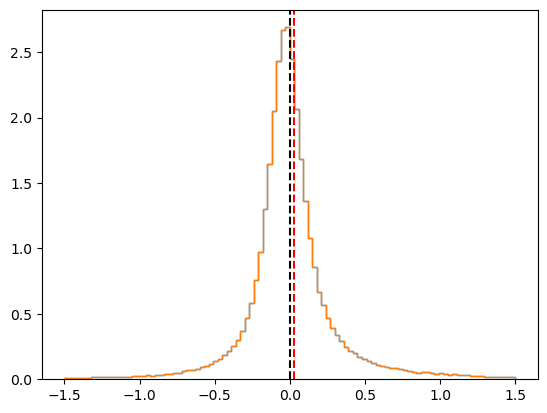

In [8]:
plt.hist(Mean_Delta_W, range=(-1.5, 1.5), bins=100, density=True, histtype='step');
plt.hist(Mean_Delta_W[delta_mask], range=(-1.5, 1.5), bins=100,density=True, histtype='step');
plt.axvline(0, color='k', linestyle='--')
plt.axvline(Mean_Delta_W_all, color='r', linestyle='--')

### convert to galactic coordinates

In [9]:
from astropy.coordinates import SkyCoord
import astropy.units as u

def convert_to_galactic(ra, dec, unit='deg', frame='icrs', theta_phi=False):
    """
    Convert RA and Dec coordinates to Galactic coordinates.

    Args:
        ra (array-like): Array of RA values in degrees.
        dec (array-like): Array of Dec values in degrees.

    Returns:
        tuple: Tuple containing Galactic longitude and latitude arrays.
    """
    q_sc = SkyCoord(ra=ra, dec=dec, unit=unit, frame=frame)
    q = q_sc.galactic

    q_ra = q.l.degree
    q_dec = q.b.degree
    if theta_phi:
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)

        # Calculate theta and phi
        theta = np.pi/2 - dec_rad
        phi = ra_rad
        return theta, phi
    else:
        return q_ra, q_dec
    

def ra_dec_to_theta_phi(ra, dec):
    """
    Convert Right Ascension (RA) and Declination (Dec) coordinates to theta and phi coordinates.

    Parameters:
        ra (float): Right Ascension in degrees.
        dec (float): Declination in degrees.

    Returns:
        tuple: Theta and Phi coordinates in radians.
    """
    # Convert degrees to radians
    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec) 

    # Calculate theta and phi
    theta = np.pi/2 - dec_rad
    phi = ra_rad

    return theta, phi

def make_healpix_density_map(ra, dec, nside, weights=None, save_map=False, save_name=None, do_plot=False, title=None):
    """
    takes in a catalogue and makes healpix map
    """
    nside_lr = 16
    pixels = hp.ang2pix(nside, theta=ra, phi=dec, lonlat=True)
    pixels_lr = hp.ang2pix(nside_lr, theta=ra, phi=dec, lonlat=True)
    if weights is not None:
        fmap = np.bincount(pixels, weights=weights, minlength=hp.nside2npix(nside))
        fmap_lr = np.bincount(pixels_lr, weights=weights, minlength=hp.nside2npix(nside_lr))
    else:
        fmap = np.bincount(pixels, minlength=hp.nside2npix(nside))
        fmap_lr = np.bincount(pixels_lr, minlength=hp.nside2npix(nside_lr))

    if save_name is not None and save_map:
        hp.write_map(save_name, fmap, overwrite=True)
    if do_plot:
        # Mask pixels that are zero in grey
        mask = fmap_lr == 0
        fmap_lr[mask] = np.nan
        hp.mollview(fmap_lr, title='%s (Nside=16)'%title);plt.show()
    return fmap



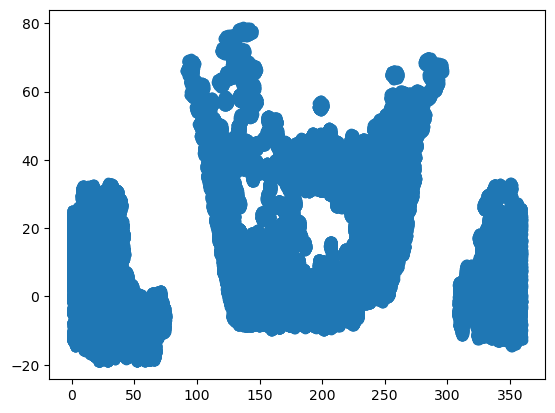

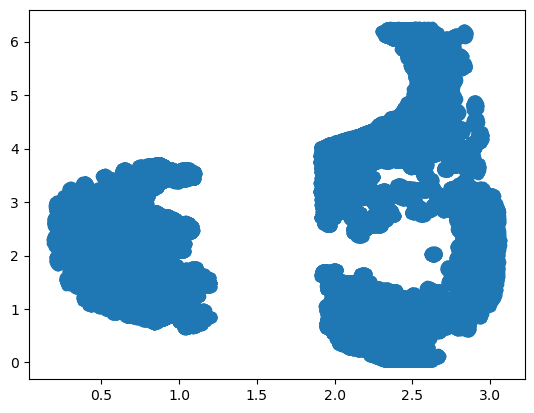

In [10]:

plt.scatter(data['RA'], data['Dec']);plt.show()

# Create SkyCoord object with RA and Dec data in degrees
c_icrs = SkyCoord(data['RA']* u.deg, data['Dec']* u.deg, frame='icrs')

# Transform coordinates to Galactic frame
c_galactic = c_icrs.transform_to('galactic')

# Extract theta and phi angles in radians
tdata_rad = c_galactic.spherical.lat  # Galactic  in radians
pdata_rad = c_galactic.spherical.lon    # Galactic  in radians

tdata = tdata_rad.to(u.rad).value+np.pi/2.
pdata = pdata_rad.to(u.rad).value

plt.scatter(tdata, pdata);plt.show()


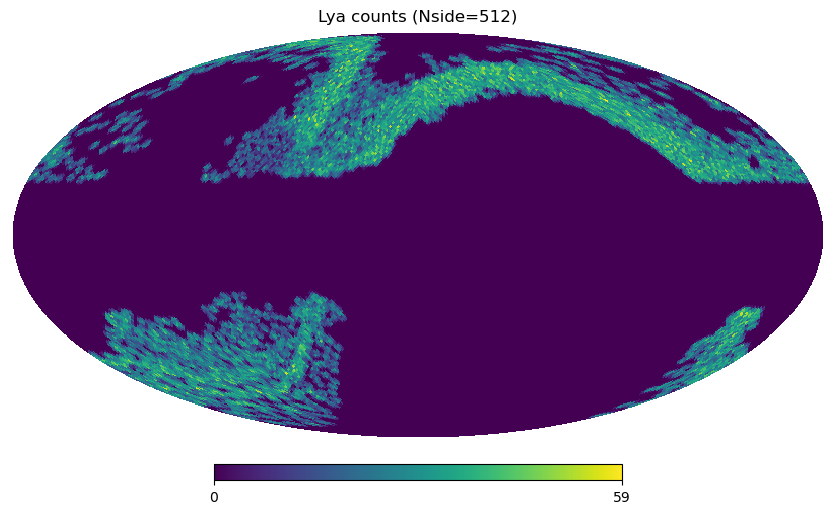

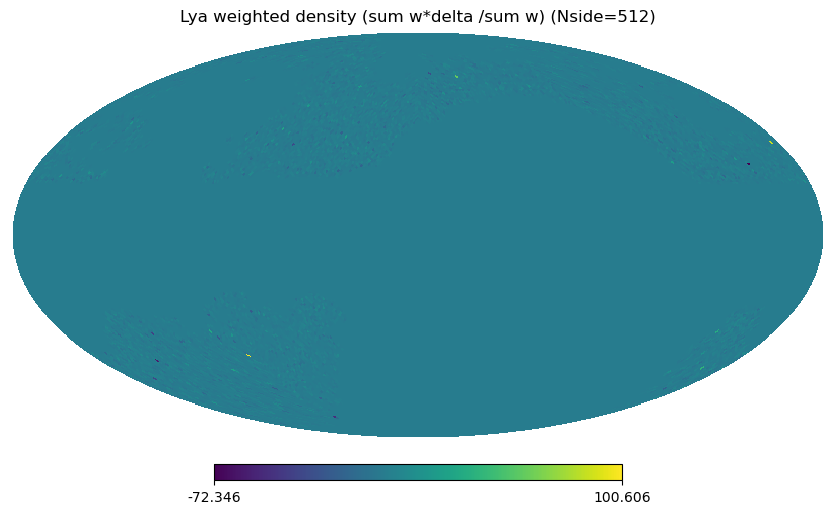

In [11]:
mm = make_healpix_density_map(c_galactic.l.value, c_galactic.b.value, nside=64, weights=None, save_map=False, save_name=None, do_plot=False, title=None)
hp.mollview(mm, title='Lya counts (Nside=512)');plt.show()
mm = make_healpix_density_map(c_galactic.l.value, c_galactic.b.value, nside=64, weights=Mean_Delta_W, save_map=False, save_name=None, do_plot=False, title=None)
hp.mollview(mm, title='Lya weighted density (sum w*delta /sum w) (Nside=512)');plt.show()
#hp.write_map('/pscratch/sd/r/rmvd2/CMBxLya/data/lya_mean_delta_weights.fits', mm)

## load Planck maps 

In [11]:
def unmask(x, mask):
    y=np.zeros(len(mask))
    y[mask==1] = x
    return y

In [12]:
# NPIPE
fcmb = '/global/cfs/cdirs/cmb/data/planck2020/PR4_lensing/PR4_klm_dat_p.fits'
fmask = '/global/cfs/cdirs/cmb/data/planck2020/PR4_lensing/mask.fits.gz'

# Planck PR3
fcmb  = '/pscratch/sd/r/rmvd2/CMBxLya/data/COM_Lensing_4096_R3.00/MV/dat_klm.fits'
fmask = '/pscratch/sd/r/rmvd2/CMBxLya/data/COM_Lensing_4096_R3.00/mask.fits.gz'

NSIDE=2048

cmb_alm = hp.read_alm(fcmb)
cmb_map = hp.alm2map(cmb_alm, nside=NSIDE)

cmb_mask = hp.read_map(fmask)

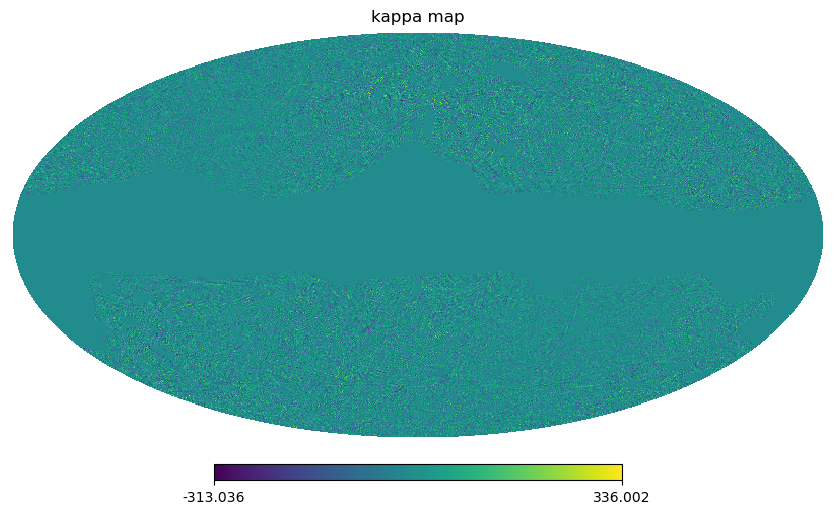

In [13]:
hp.mollview(unmask(cmb_map[cmb_mask==1], cmb_mask), title='kappa map')

In [14]:
cl_cmb = hp.anafast(cmb_map*cmb_mask, lmax=1000)

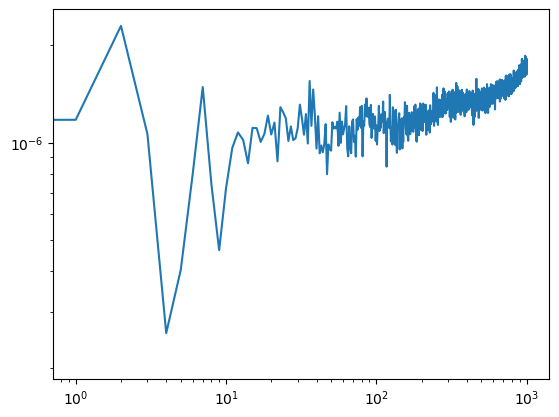

In [15]:
plt.loglog(cl_cmb)

## Harmonic analysis

First do a "direct harmonic analysis" of the data and random points by applying the SHT, differencing, and then computing the psuedo-spectrum.  We will start by finding the window function from the randoms ...

In [105]:
# Set up an sht instance.
Nl   = 1000
Nx   = 2*Nl
xmax = 3./4.
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

KeyboardInterrupt: 

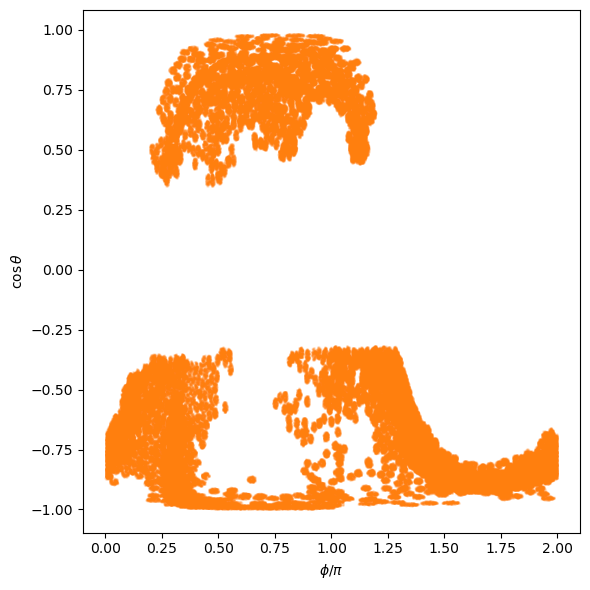

In [90]:
# plt.scatter(tdata, pdata)

fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(pdata/np.pi,np.cos(tdata),s=1,c='C1',alpha=0.1,label='Data',rasterized=False)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()

Sorting & digitizing took  0.0429379940032959  seconds.
Reshaping took  0.01602482795715332  seconds.
Precomputing vs took  0.23365020751953125  seconds.
Computing alm's took  0.11885476112365723  seconds.
Sorting & digitizing took  0.005460500717163086  seconds.
Reshaping took  0.014611244201660156  seconds.
Precomputing vs took  0.21149682998657227  seconds.
Computing alm's took  0.09528946876525879  seconds.
Sorting & digitizing took  0.0046885013580322266  seconds.
Reshaping took  0.011620044708251953  seconds.
Precomputing vs took  0.23211026191711426  seconds.
Computing alm's took  0.08383917808532715  seconds.
Sorting & digitizing took  0.00794839859008789  seconds.
Reshaping took  0.014580488204956055  seconds.
Precomputing vs took  0.33612704277038574  seconds.
Computing alm's took  0.08468365669250488  seconds.
Sorting & digitizing took  0.006579875946044922  seconds.
Reshaping took  0.020712614059448242  seconds.
Precomputing vs took  0.2921876907348633  seconds.
Computing a

Text(0, 0.5, '$\\hat{C}_\\ell$')

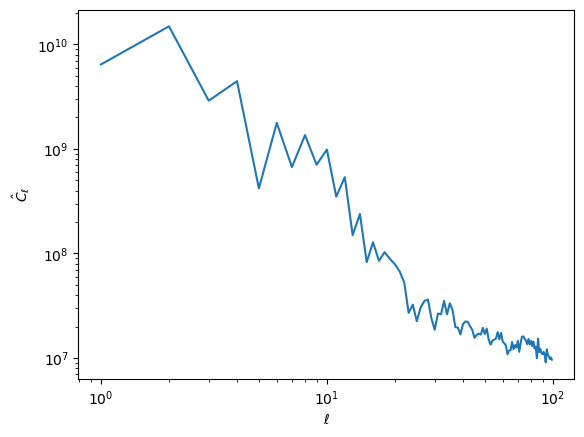

In [96]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(tdata,pdata,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')

In [97]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(tdata,pdata,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
# sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2

# ignore shot noise for now

wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.008390426635742188  seconds.
Reshaping took  0.045505523681640625  seconds.
Precomputing vs took  1.9268920421600342  seconds.
Computing alm's took  0.44824719429016113  seconds.
Sorting & digitizing took  0.006760358810424805  seconds.
Reshaping took  0.0163424015045166  seconds.
Precomputing vs took  0.3582265377044678  seconds.
Computing alm's took  0.3104381561279297  seconds.
Sorting & digitizing took  0.0044858455657958984  seconds.
Reshaping took  0.010853767395019531  seconds.
Precomputing vs took  0.4800233840942383  seconds.
Computing alm's took  0.3232548236846924  seconds.
Sorting & digitizing took  0.007825374603271484  seconds.
Reshaping took  0.01333761215209961  seconds.
Precomputing vs took  0.5264945030212402  seconds.
Computing alm's took  0.3627593517303467  seconds.


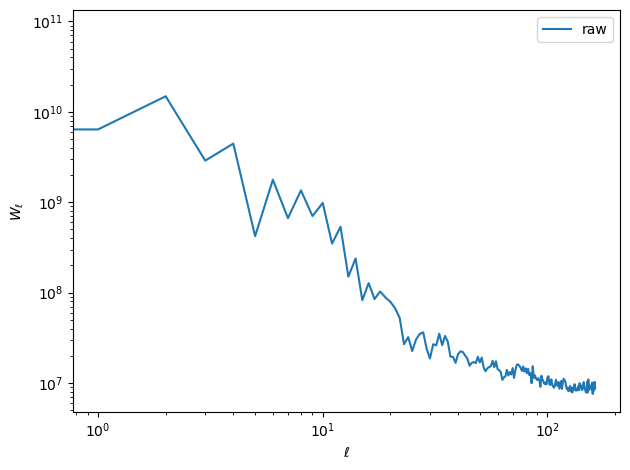

In [98]:
plt.loglog(wl,label='raw')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
#plt.savefig('harmonic_window.pdf')

In [99]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 5.24 s, sys: 80.9 ms, total: 5.32 s
Wall time: 8.19 s

Row sums of Mbl:
[1.00551321 1.0048861  1.00638372 1.00503432 1.04708208]


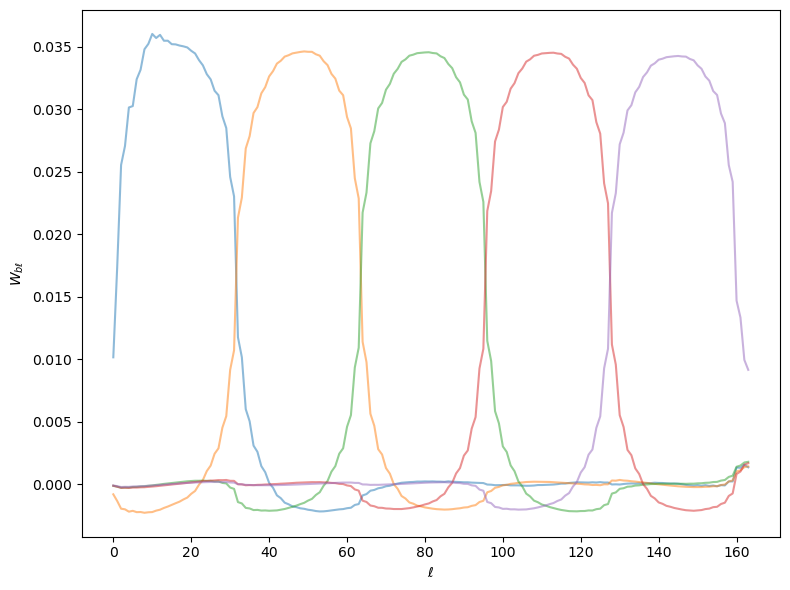

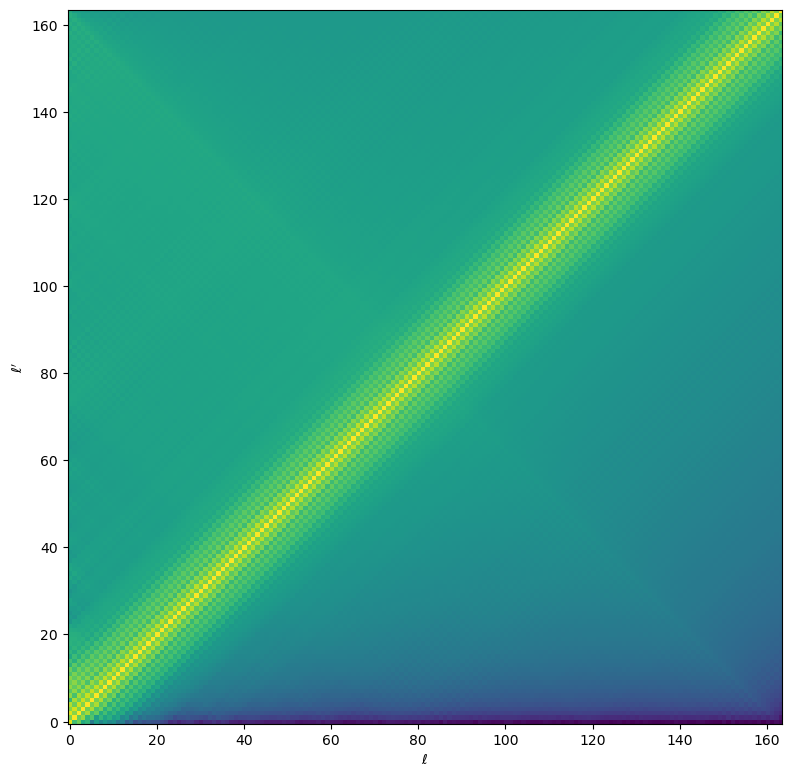

In [100]:
# Plot the matrix:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('harmonic_wbl.pdf')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1,figsize=(8,8))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
#plt.savefig('harmonic_mll.pdf')

In [101]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [102]:
print(binned_ells)
print(hdif_decoupled)

[79.5]
[-0.00163136]


/tmp/ipykernel_333914/2161324776.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


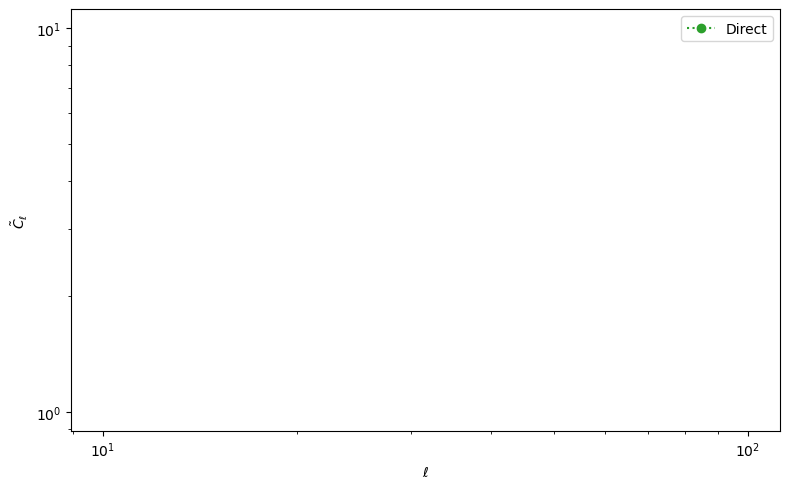

In [103]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
#clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
#ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
#plt.savefig('harmonic_tildeC.pdf')

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

In [21]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = hp.nside2npix(nside)
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

We don't have enough randoms to get a good outcome with a pixel-based analysis, so let's generate more.

In [22]:
# Generate the randoms.
nrand = 70*ndata
trand2,prand2,wrand2 = generate_randoms(nrand)
# Run the data and randoms through the "veto mask".
trand2,prand2,wrand2 = veto_points(trand2,prand2,wrand2,nveto,rveto)
# Append the new randoms to the end of the old randoms.
trand  = np.append(trand,trand2)
prand  = np.append(prand,prand2)
wrand  = np.append(wrand,wrand2)
# Redo the weights.
nrand  = len(trand)
wrand *= np.sum(wdata)/np.sum(wrand)

dmap.sum= 32434325379.379616
rmap.sum= 32434325379.368603
fsky= 0.3385607401529948


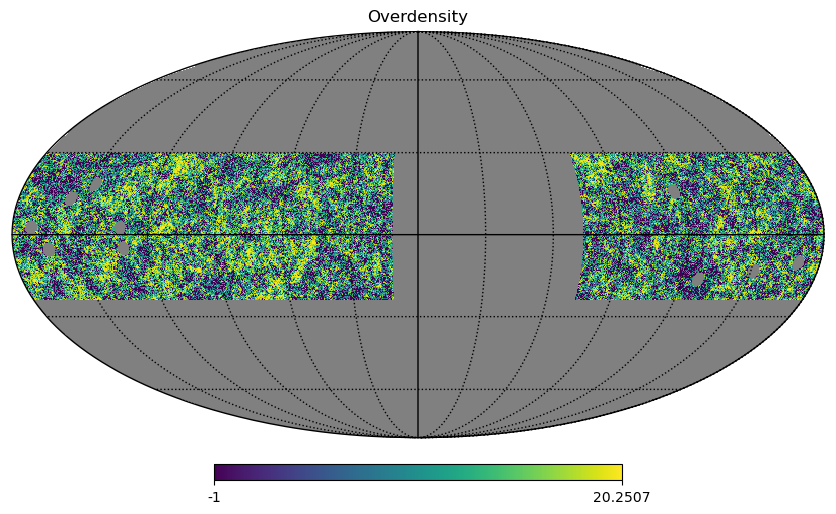

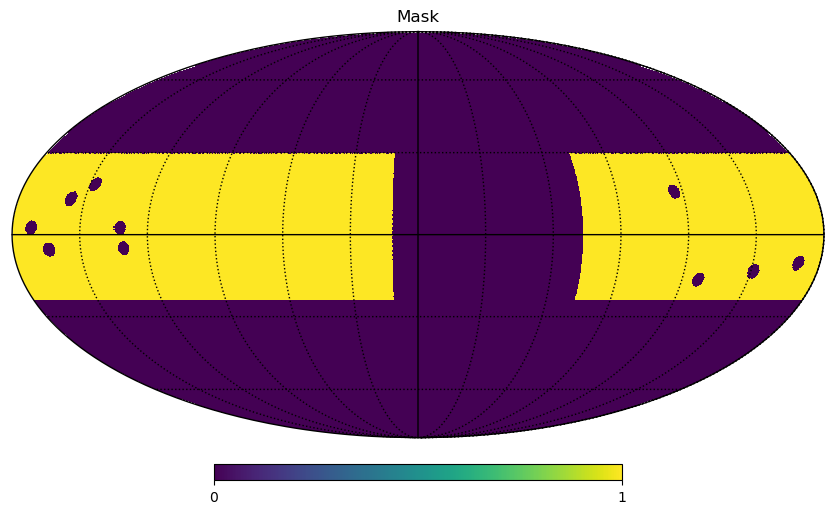

In [23]:
# Show an example at some nside.
nside= 256
npix = hp.nside2npix(nside)
dmap = make_map(tdata,pdata,wdata,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
#
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
msk = np.nonzero(rmap>0.5*avg)[0]
#
omap      = np.zeros(npix,dtype='f8')
omap[msk] = dmap[msk]/rmap[msk]
omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
mask      = np.zeros(npix)
mask[msk] = 1.0
#
fsky = len(msk)/float(len(mask))
print("fsky=",fsky)
#
ma = hp.ma(omap)
ma.mask = (mask<0.5)
hp.mollview(ma,norm='hist',title='Overdensity')
hp.graticule()
plt.savefig('overdensity.pdf')
#
hp.mollview(mask,title='Mask')
hp.graticule()

Text(0, 0.5, '$\\hat{C}_\\ell$')

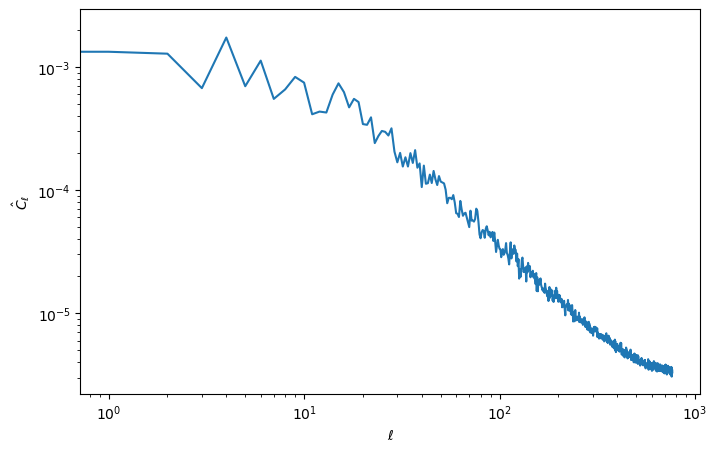

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
#
cl_via_map = hp.anafast(omap)
ax.loglog(cl_via_map[1:-1])
#
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')

In [25]:
# Measure the W_l
wl_maplevel = hp.anafast(mask)

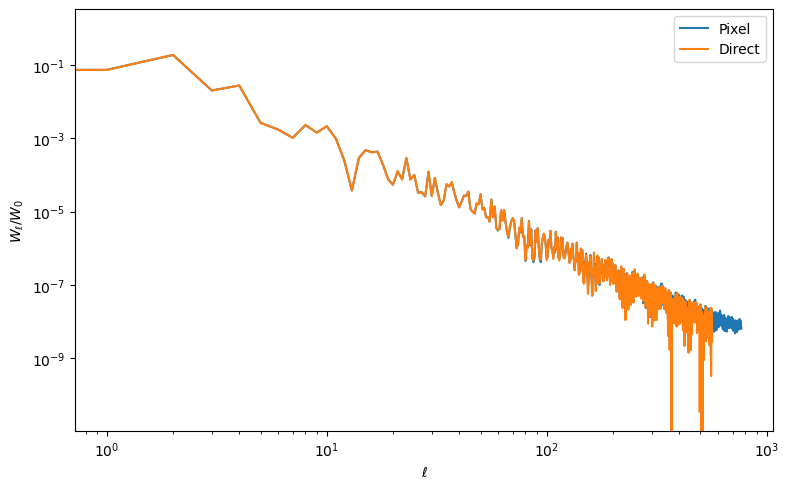

In [26]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.loglog(wl_maplevel/wl_maplevel[0],label='Pixel')
ax.loglog(wl/wl[0],label='Direct')
#
ax.legend()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_\ell/W_0$')
#
plt.tight_layout()

In [27]:
# We will initialize a different mode-decoupling object
# because our map-level mask has a different normalization
# (of course we could just renormalize...)
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)
#
# Deconvolve the mask to produce a "map delta" estimate of tilde{C}_ell.
binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard], mdel_decoupled[Ndiscard:-Ndiscard]

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


Text(0, 0.5, '$\\hat{C}_\\ell$')

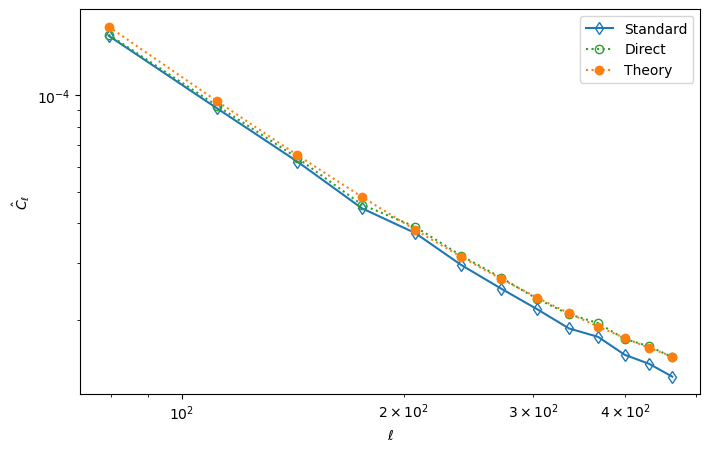

In [28]:
# Let's just plot the angular power spectrum so we know what we've got.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,mdel_decoupled,'d-',color='C0',\
        mfc='None',label='Standard')
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',\
        mfc='None',label='Direct')
#
# Compare to the theory convolved with the bandpower window function.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells,clt_conv[Ndiscard:-Ndiscard],'o:',\
        color='C1',label='Theory')
#
ax.legend()
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')

# Compare to the standard analysis as a function of Nside

Now we can compare the direct SHT approach to the standard one, varying the number of pixels in the "map based" analysis.

In [29]:
# Let's save ourselves some time by using the same W_l irrespective of the number of randoms.
# Another option would be to recompute this at the relevant Nside for consistency with how a
# pixel-based analysis would likely be performed.
nside = 512
npix  = hp.nside2npix(nside)
rmap  = make_map(trand,prand,wrand,nside)
#
# Make a binary mask.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
msk = np.nonzero(rmap>0.5*avg)[0]
#
mask      = np.zeros(npix)
mask[msk] = 1.0
# Measure the W_l and trim it to the same size as our direct W_l.
wl_maplevel = hp.anafast(mask)
wl_maplevel = wl_maplevel[:wl.size]

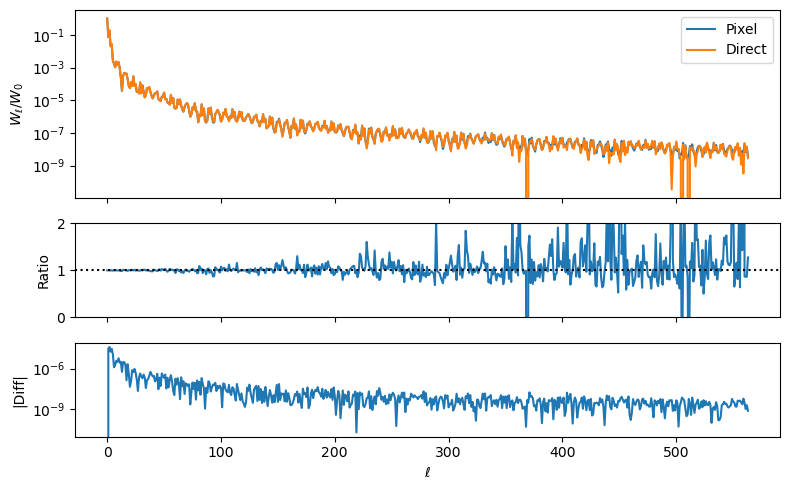

In [30]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(3,1,sharex=True,figsize=(8,5),\
                      gridspec_kw={'height_ratios':[2,1,1]})
#
ells = np.arange(wl_maplevel.size)
ax[0].plot(ells,wl_maplevel/wl_maplevel[0],label='Pixel')
ax[0].plot(ells,wl/wl[0],label='Direct')
#
ax[1].plot(ells,(wl_maplevel/wl_maplevel[0])/(wl/wl[0]))
ax[1].axhline(1.0,ls=':',color='k')
#
error = np.abs( wl_maplevel/wl_maplevel[0] - wl/wl[0] )
ax[2].plot(ells,error)
#
ax[0].legend()
ax[0].set_yscale('log')
ax[2].set_yscale('log')
ax[1].set_ylim(0,2)
ax[2].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$W_\ell/W_0$')
ax[1].set_ylabel(r'Ratio')
ax[2].set_ylabel(r'|Diff|')
#
plt.tight_layout()
#plt.savefig('compare_window.pdf')

In [31]:
# Make a mode-decoupling object to go with the mask.
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


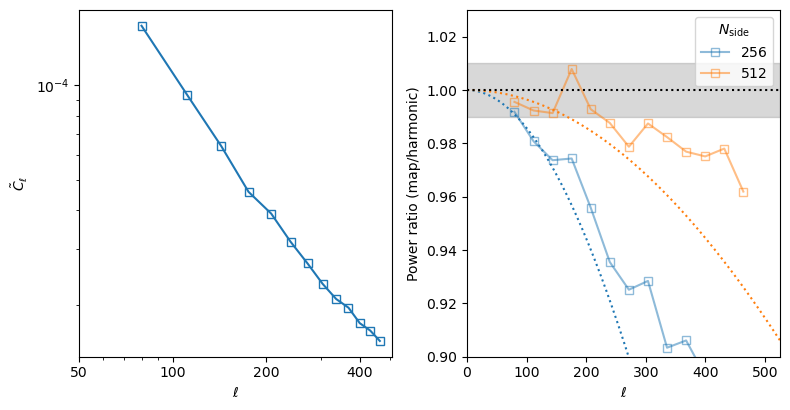

In [32]:
fig,ax = plt.subplots(1,2,sharey=False,figsize=(8,4.2))
#
xticks = [50,100,200,400]
ax[0].plot(binned_ells,hdif_decoupled,'s-',mfc='None')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(xticks,[str(x) for x in xticks])
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\tilde{C}_\ell$')
#
icol= 0
for nside in [256,512]:
    npix = hp.nside2npix(nside)
    dmap = make_map(tdata,pdata,wdata,nside)
    rmap = make_map(trand,prand,wrand,nside)
    #
    msk = np.nonzero(rmap>0)[0]
    avg = np.mean(rmap[msk])
    msk = np.nonzero(rmap>0.5*avg)[0]
    #
    omap      = np.zeros(npix,dtype='f8')
    omap[msk] = dmap[msk]/rmap[msk]
    omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
    mask      = np.zeros(npix)
    mask[msk] = 1.0
    #   
    cl_via_map= hp.anafast(omap)
    #
    # Deconvolve the mask
    binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
    binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard],mdel_decoupled[Ndiscard:-Ndiscard]
    #
    ratio= mdel_decoupled/hdif_decoupled
    pixwn= hp.pixwin(nside)
    #
    ax[1].plot(binned_ells,ratio,'s-',color='C'+str(icol),alpha=0.5,\
               mfc='None',label='${:4d}$'.format(nside))
    ax[1].plot(np.arange(pixwn.size),pixwn**2,ls=':',color='C'+str(icol))
    icol = (icol+1)%10
#   
ax[1].axhline(1.0,ls=':',color='k')
ax[1].fill_between([0,Nl+25],[0.99,0.99],[1.01,1.01],color='grey',alpha=0.3)
ax[1].set_ylabel(r'Power ratio (map/harmonic)')
ax[1].legend(title=r'$N_{\rm side}$')
ax[1].set_ylim(0.90,1.03)
ax[1].set_yscale('linear')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlim([0,Nl+25])
#
plt.tight_layout()
#plt.savefig('compare_pipelines.pdf')

Note that the exact behavior of the ratio depends upon the number of points and the geometry, since e.g. we should get the right answer either way in the shot-noise dominated regime.

# The End